##　SaveとLoad

In [1]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim, nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

### early stopping

In [2]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]

        if self.transform:
            X = self.transform(X)

        return X, y
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.flatten = nn.Flatten() # [b, c, h, w] -> [b, cxhxw]
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        # z1 = self.l1(x)
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(self.flatten(x))))
        return x

# 学習ループを関数化
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        
        for train_batch, data in enumerate(train_loader):
            
            X, y = data
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            optimizer.step()
    
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies
        

In [3]:
# データロード
dataset = datasets.load_digits()
target = dataset['target']
images = dataset['images']
images = images * (255. / 16.) # 0~16 -> 0~255
images = images.astype(np.uint8)
# 学習データと検証データ作成
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# DatasetとDataLoader作成
transform = transforms.Compose([
    transforms.ToTensor(),# 0~255 -> 0~1
    transforms.Normalize((.5, ), (.5, )) # 0~1 -> -1~1
])

batch_size = 32 
train_dataset = MyDataset(X_train, y_train, transform=transform)
val_dataset = MyDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
early_stopping = 5
## Refactoring後の学習ループ
learning_rate = 0.1
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
num_epoch = 100
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5)

epoch: 0: train error: 1.7054140594270495, validation error: 1.0471082776784897, validation accuracy: 0.8177083333333334
epoch: 1: train error: 0.6928016463915507, validation error: 0.5008646647135416, validation accuracy: 0.8802083333333334
epoch: 2: train error: 0.38037851916419135, validation error: 0.34768162916104, validation accuracy: 0.9010416666666666
epoch: 3: train error: 0.2685206577181816, validation error: 0.2689857954780261, validation accuracy: 0.9244791666666666
epoch: 4: train error: 0.21555731528335148, validation error: 0.220975112169981, validation accuracy: 0.9479166666666666
epoch: 5: train error: 0.18340755419598687, validation error: 0.18528479896485806, validation accuracy: 0.9505208333333334
epoch: 6: train error: 0.1657624943388833, validation error: 0.16652311012148857, validation accuracy: 0.953125
epoch: 7: train error: 0.14388660374614928, validation error: 0.1550407251343131, validation accuracy: 0.9375
epoch: 8: train error: 0.1334268088142077, validati

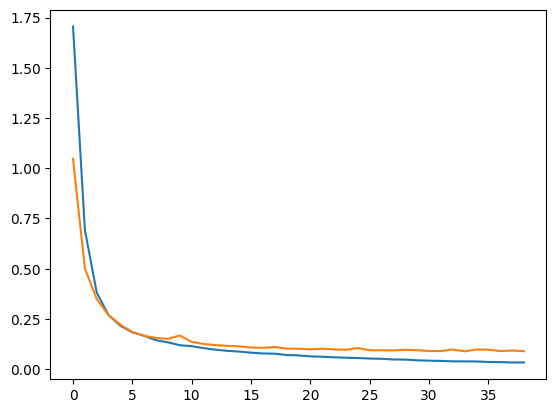

In [4]:
plt.plot(train_losses)
plt.plot(val_losses)

### モデルオブジェクトの保存とロード

In [5]:
torch.save(model, 'sample_model.pth')
loaded_model = torch.load('sample_model.pth')
loaded_model

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)

### モデルパラメータの保存とロード

In [6]:
params = model.state_dict()
another_model = MLP(64, 30, 10)
another_model.load_state_dict(params)

<All keys matched successfully>

In [7]:
torch.save(model.state_dict(), 'sample_model_state_dict.pth')
another_model.load_state_dict(torch.load('sample_model_state_dict.pth'))

<All keys matched successfully>

In [8]:
# モデル保存付き
def learn(model, train_loader, val_loader, optimizer, loss_func, num_epoch, early_stopping=None, save_path=None):
    # ログ
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    no_improve = 0 # カウント用変数
    
    for epoch in range(num_epoch):
        running_loss = 0.0
        running_val_loss = 0.0
        running_val_acc = 0.0
        
        for train_batch, data in enumerate(train_loader):
            
            X, y = data
            optimizer.zero_grad()
            # forward
            preds = model(X)
            loss = loss_func(preds, y)
            running_loss += loss.item()
    
            # backward
            loss.backward()
            optimizer.step()
    
        # validation
        with torch.no_grad():
            for val_batch, data in enumerate(val_loader):
                X_val, y_val = data
                preds_val = model(X_val)
                val_loss = loss_func(preds_val, y_val)
                running_val_loss += val_loss.item()
                val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]
                running_val_acc += val_accuracy.item()
    
        train_losses.append(running_loss/(train_batch + 1))
        val_losses.append(running_val_loss/(val_batch + 1))
        val_accuracies.append(running_val_acc/(val_batch + 1))
        print(f'epoch: {epoch}: train error: {train_losses[-1]}, validation error: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}')
    
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve = 0
            if save_path is not None:
                state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_losses[-1]
                }
                torch.save(state, save_path)
        else:
            no_improve += 1
    
        if early_stopping and no_improve >= early_stopping:
            print('Stopping early')
            break

    return train_losses, val_losses, val_accuracies
        

In [9]:
model = MLP(64, 30, 10)
opt = optim.SGD(model.parameters(), lr=learning_rate)
train_losses, val_losses, val_accuracies = learn(model, train_loader, val_loader, opt, F.cross_entropy, num_epoch, early_stopping=5, save_path='checkpoint')

epoch: 0: train error: 1.8902304066552056, validation error: 1.291235665480296, validation accuracy: 0.7604166666666666
epoch: 1: train error: 0.8458498160044352, validation error: 0.540640746553739, validation accuracy: 0.8958333333333334
epoch: 2: train error: 0.4307652817832099, validation error: 0.3458210999766986, validation accuracy: 0.9322916666666666
epoch: 3: train error: 0.2919006453620063, validation error: 0.27114536116520566, validation accuracy: 0.9375
epoch: 4: train error: 0.23118400557173624, validation error: 0.21790571883320808, validation accuracy: 0.9427083333333334
epoch: 5: train error: 0.19631932708952163, validation error: 0.18689150673647723, validation accuracy: 0.9557291666666666
epoch: 6: train error: 0.16666459855106142, validation error: 0.1818670965731144, validation accuracy: 0.9453125
epoch: 7: train error: 0.1515703934762213, validation error: 0.15223536764582, validation accuracy: 0.9479166666666666
epoch: 8: train error: 0.13705768353409237, validat

In [10]:
state = torch.load('checkpoint')
model.load_state_dict(state['model_state_dict'])
opt.load_state_dict(state['optimizer_state_dict'])